In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from keras.layers import *
from keras.models import Sequential, Model

## Check for GPUs if used

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Now you can proceed with your TensorFlow code
        # ...
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found.")

No GPU devices found.


### Project overview: 
#### We will be building a deep audio binary classifier which will be a hybrid one containing the spectrogram classification and also the mfcc features classification , we will be using functional API of tensorflow for this purpose

In [3]:
import librosa

In [4]:
def load_mono_audio(filename):
    wav,sample_rate=librosa.load(filename,sr=16000)
    return wav

In [5]:
import os

In [6]:
capuchin_file='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114131-0.wav'
not_capuchin_file='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav'
demo_sample_rate=16000

## Demo Samples

In [7]:
demo_capuchin=load_mono_audio(capuchin_file)

In [8]:
len(demo_capuchin)

40000

In [9]:
demo_sample_rate

16000

In [10]:
demo_not_capuchin=load_mono_audio(not_capuchin_file)
demo_not_capuchin

array([ 3.3416259e-10, -6.3695674e-11, -1.8498189e-11, ...,
        3.1805006e-03, -3.0506108e-04, -6.2287906e-03], dtype=float32)

## Sample Audio Wave

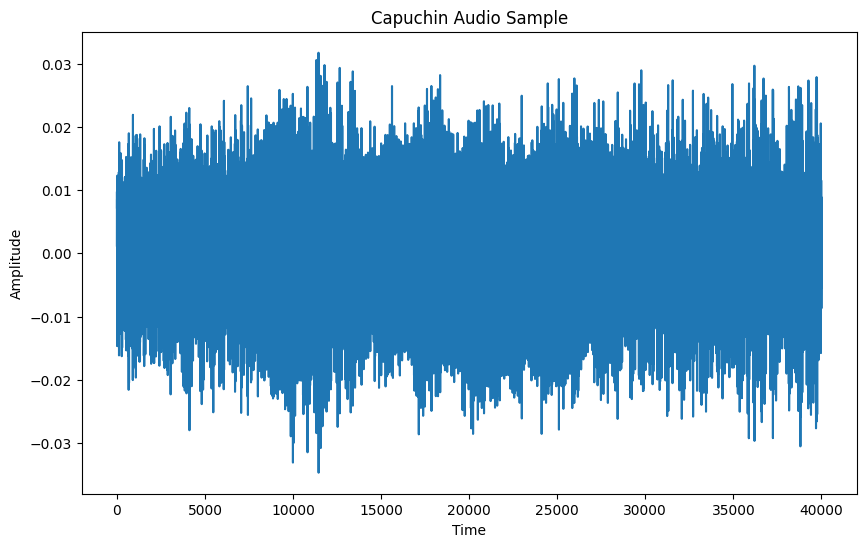

In [11]:
plt.figure(figsize=(10,6))
plt.title('Capuchin Audio Sample')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(demo_capuchin)

## MFCC features

In [12]:
demo_audio_features=librosa.feature.mfcc(y=demo_capuchin,sr=demo_sample_rate,n_mfcc=100)

In [13]:
demo_audio_features

array([[-4.2628784e+02, -3.9398621e+02, -3.9522287e+02, ...,
        -3.7270776e+02, -3.7075922e+02, -3.8388504e+02],
       [ 6.2708435e+01,  6.2472740e+01,  6.0977314e+01, ...,
         7.0194214e+01,  7.1223770e+01,  6.8122574e+01],
       [ 3.4185699e+01,  2.9073746e+01,  2.8802540e+01, ...,
         2.3060104e+01,  2.5452787e+01,  2.7663431e+01],
       ...,
       [-8.8200021e-01, -1.6484157e+00, -8.6430115e-01, ...,
        -1.0292959e-01, -1.1004279e+00, -3.0983322e+00],
       [-2.5902288e+00, -1.7819781e+00, -1.9178538e+00, ...,
        -2.0941067e-01, -1.2512801e+00, -1.3920093e-01],
       [ 2.1532965e+00,  1.8737978e+00, -2.0857811e-02, ...,
         2.5551088e+00,  2.8671169e-01, -6.2442863e-01]], dtype=float32)

In [14]:
demo_audio_features.mean(axis=0).shape

(79,)

## Length of cycles

In [15]:
import os

In [16]:
pos_path='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/'
neg_path='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/'

In [17]:
lengths = []
for file in os.listdir("/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips"):
    tensor_wave = load_mono_audio(os.path.join(pos_path, file))
    lengths.append(len(tensor_wave))

In [18]:
tf.math.reduce_mean(lengths).numpy()

54156

In [19]:
tf.math.reduce_min(lengths).numpy()

32000

In [20]:
tf.math.reduce_max(lengths).numpy()

80000

In [21]:
demo_audio_features.mean(axis=0)

array([-4.120883 , -3.7980435, -4.324215 , -3.9913719, -3.9873397,
       -4.0910244, -3.6520157, -3.9262455, -3.864076 , -3.4221704,
       -3.300804 , -3.6507983, -3.87904  , -4.1051974, -4.0579686,
       -4.054144 , -3.9279935, -3.8791046, -3.8318768, -3.6906278,
       -3.7847955, -3.294109 , -3.3644748, -3.290089 , -3.3671246,
       -3.6497436, -4.0968547, -3.8696105, -3.3584366, -3.8024292,
       -4.1509666, -4.1760054, -4.1315093, -3.8475611, -3.790397 ,
       -3.7455692, -4.140222 , -4.191708 , -4.135435 , -4.163988 ,
       -3.9514349, -3.9914923, -4.3987403, -4.247158 , -3.83134  ,
       -3.5250406, -3.4895353, -3.7622244, -3.8706837, -3.800689 ,
       -4.153938 , -4.445909 , -3.8764956, -3.7296622, -3.9812076,
       -3.8620727, -3.8859606, -3.5378036, -3.5089464, -3.71552  ,
       -4.1146526, -3.999814 , -3.6657245, -3.3726585, -3.176533 ,
       -3.5036182, -3.9402049, -3.9620297, -3.7186973, -3.5293074,
       -3.1666605, -3.262513 , -3.4534912, -3.4944935, -3.9530

In [22]:
def make_spectrogram(wav):
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [23]:
spec_gram=make_spectrogram(demo_capuchin)

In [24]:
spec_gram.shape

TensorShape([1241, 257, 1])

In [25]:
tf.transpose(spec_gram)[0].shape

TensorShape([257, 1241])

## Spectrogram for Audio

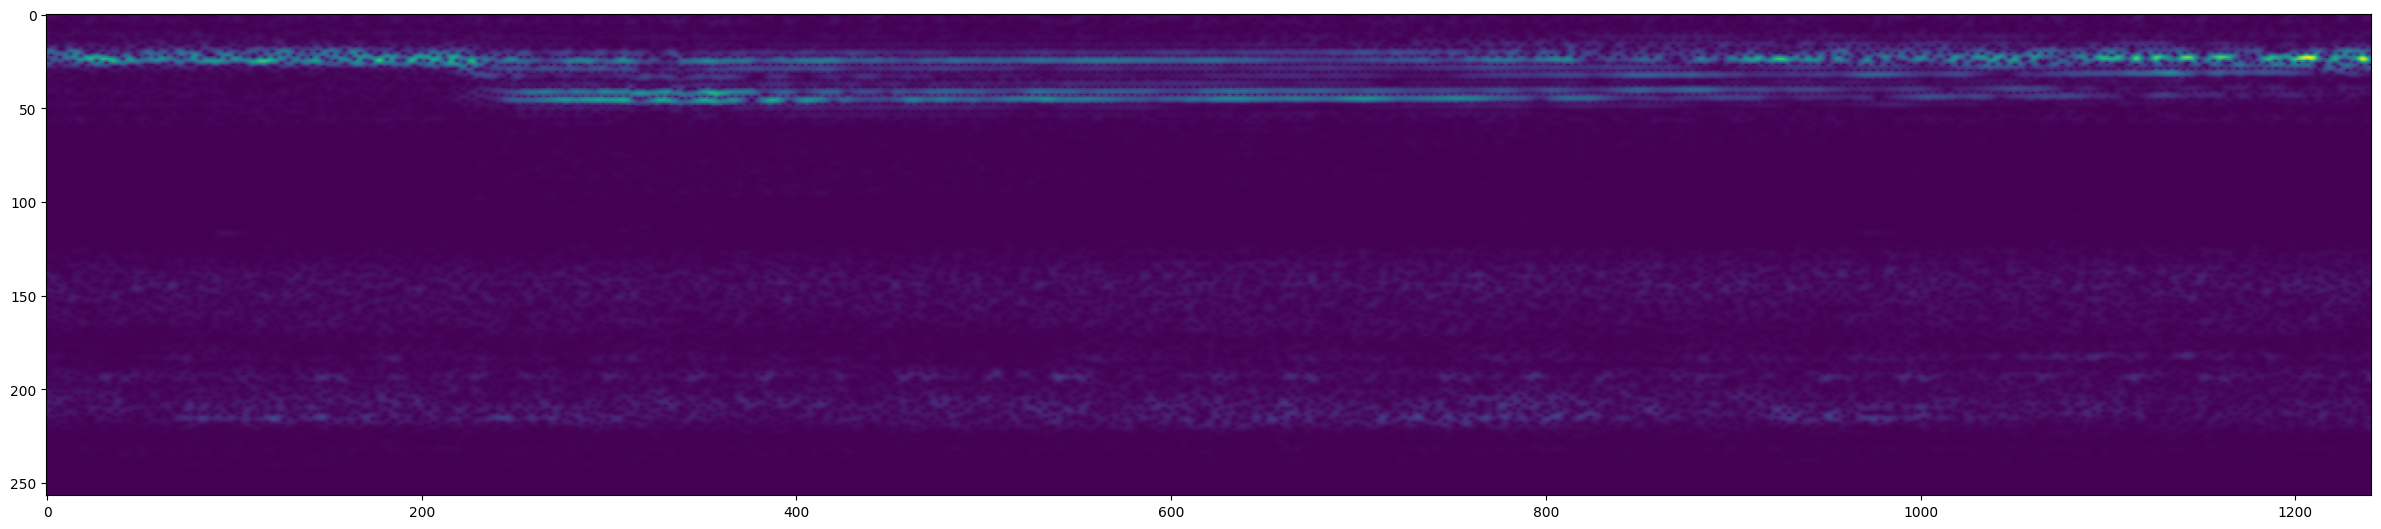

In [26]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spec_gram)[0])
plt.show()

In [27]:
from tqdm import tqdm

## Extracting the mfcc features of postive and negative samples

In [30]:
def extract_mfcc_features(file_path,index=None):
    wav_file=load_mono_audio(file_path)
    demo_audio_features=librosa.feature.mfcc(y=wav_file,sr=demo_sample_rate,n_mfcc=100)
    return demo_audio_features.mean(axis=0)

In [31]:
positive_mfcc=[]
negative_mfcc=[]

In [32]:
pos_path='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/'
neg_path='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/'

In [33]:
for pos_file in tqdm(os.listdir(pos_path)):
    positive_mfcc.append(extract_mfcc_features(pos_path+pos_file))

100%|██████████| 217/217 [00:08<00:00, 26.60it/s]


In [34]:
for neg_file in tqdm(os.listdir(neg_path)):
    negative_mfcc.append(extract_mfcc_features(neg_path+neg_file))   

100%|██████████| 593/593 [00:31<00:00, 18.88it/s]


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
len(positive_mfcc),len(negative_mfcc)

(217, 593)

## Padding the sequences for same length

In [37]:
max_length_neg = max(mfcc.shape[0] for mfcc in negative_mfcc)
max_length_pos = max(mfcc.shape[0] for mfcc in positive_mfcc)
max_length=max(max_length_neg,max_length_pos)
padded_negative_mfcc = []
for mfcc in negative_mfcc:
    if mfcc.shape[0] < max_length:
        padded_mfcc = pad_sequences([mfcc], dtype='float32', padding='pre', maxlen=max_length)
    else:
        padded_mfcc = mfcc[:max_length]
    padded_negative_mfcc.append(padded_mfcc)
negative_mfcc_array = np.vstack(padded_negative_mfcc)

In [115]:
np.array(padded_negative_mfcc).shape

(593, 1, 157)

In [38]:
positive_mfcc[0].shape,negative_mfcc_array.shape

((126,), (593, 157))

In [39]:
len(positive_mfcc)

217

In [40]:
max_length

157

In [41]:
padded_positive_mfcc = []
for mfcc in positive_mfcc:
    if mfcc.shape[0] < max_length:
        padded_mfcc = pad_sequences([mfcc], dtype='float32', padding='pre', maxlen=max_length)
    else:
        padded_mfcc = mfcc[:max_length]
    padded_positive_mfcc.append(padded_mfcc)
positive_mfcc_array = np.vstack(padded_positive_mfcc)

In [42]:
negative_mfcc_array.shape, positive_mfcc_array.shape

((593, 157), (217, 157))

In [43]:
combined_mfcc = np.concatenate((negative_mfcc_array, positive_mfcc_array), axis=0)

In [44]:
combined_mfcc

array([[ 0.        ,  0.        ,  0.        , ..., -7.1499357 ,
        -7.0671577 , -6.399331  ],
       [ 0.        ,  0.        ,  0.        , ..., -1.6400168 ,
        -1.6436706 , -2.1183817 ],
       [ 0.        ,  0.        ,  0.        , ..., -4.1631517 ,
        -4.5280876 , -5.1480904 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -3.1167276 ,
        -2.9836168 , -3.40395   ],
       [ 0.        ,  0.        ,  0.        , ..., -5.394793  ,
        -4.0385547 , -3.0880516 ],
       [ 0.        ,  0.        ,  0.        , ..., -1.1040707 ,
        -0.94681895, -1.1508156 ]], dtype=float32)

In [45]:
combined_mfcc.shape

(810, 157)

# Spectogram Features for CNN

In [46]:
# def preprocess(file_path, label): 
#     wav = load_wav_16k_mono(file_path)
#     wav = wav[:48000]
#     mfcc=extract_mfcc_features(wav)
#     zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
#     wav = tf.concat([zero_padding, wav],0)
#     spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
#     spectrogram = tf.abs(spectrogram)
#     spectrogram = tf.expand_dims(spectrogram, axis=2)
#     return spectrogram, label

def preprocess(file_path): 
    wav = load_mono_audio(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [47]:
positive_spec=[]
negative_spec=[]
for neg_file in tqdm(os.listdir(neg_path)):
    negative_spec.append(preprocess(neg_path+neg_file))   

100%|██████████| 593/593 [00:23<00:00, 25.06it/s]


In [48]:
for pos_file in tqdm(os.listdir(pos_path)):
    positive_spec.append(preprocess(pos_path+pos_file))   

100%|██████████| 217/217 [00:08<00:00, 25.92it/s]


In [49]:
len(positive_spec)

217

In [50]:
positive_spec[:3]

[<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
 array([[[4.54007313e-02],
         [3.57611328e-01],
         [4.86219943e-01],
         ...,
         [8.82082459e-05],
         [1.56133392e-04],
         [5.65890223e-05]],
 
        [[2.61303186e-01],
         [3.33094656e-01],
         [3.48972410e-01],
         ...,
         [3.11585580e-04],
         [9.55785072e-05],
         [1.99198723e-04]],
 
        [[3.14848274e-01],
         [3.24144989e-01],
         [2.52782941e-01],
         ...,
         [1.09759276e-04],
         [1.83721597e-04],
         [2.97158957e-04]],
 
        ...,
 
        [[1.02018967e-01],
         [5.63190639e-01],
         [8.40274453e-01],
         ...,
         [3.26854206e-04],
         [1.63483492e-04],
         [9.69730318e-05]],
 
        [[4.25178081e-01],
         [5.95668495e-01],
         [7.28385687e-01],
         ...,
         [2.63591413e-04],
         [3.63923376e-04],
         [6.34789467e-06]],
 
        [[5.63196421e-01],
      

In [51]:
positive_spec_array=np.array([tensor.numpy() for tensor in positive_spec])
negative_spec_array=np.array([tensor.numpy() for tensor in negative_spec])

In [52]:
positive_spec_array.shape

(217, 1491, 257, 1)

In [53]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [54]:
negative_spec_array.shape

(593, 1491, 257, 1)

In [55]:
positive_mfcc_array.shape

(217, 157)

In [56]:
import pandas as pd

In [57]:
spectro_features=np.concatenate((positive_spec_array,negative_spec_array),axis=0)

In [58]:
spectro_features.shape

(810, 1491, 257, 1)

In [59]:
mfcc_features=np.concatenate((positive_mfcc_array,negative_mfcc_array),axis=0)

In [60]:
type(mfcc_features)

numpy.ndarray

In [61]:
mfcc_features.shape

(810, 157)

In [62]:
y=np.concatenate((np.ones(len(positive_spec)),np.zeros(len(negative_spec))))

In [63]:
y.shape

(810,)

# Train test split

In [65]:
from sklearn.model_selection import train_test_split

# Assuming X_spectro and X_mfcc are your two input arrays, and y is your target variable
X_train_spectro, X_test_spectro, X_train_mfcc, X_test_mfcc, y_train, y_test = train_test_split(spectro_features, mfcc_features, y, test_size=0.2, random_state=42)

## Creating Model

In [66]:
def create_model():
    input_shape_spectrogram = (1491, 257, 1)
    inp1 = Input(shape=input_shape_spectrogram)
    norm=BatchNormalization()(inp1)
#     resized_features = tf.keras.layers.experimental.preprocessing.Resizing(229, 229)(inp1)  
    conv1 = Conv2D(32, (3, 3), activation='relu')(norm)
    conv2 = Conv2D(16, (3, 3), activation='relu')(conv1)
    flat = Flatten()(conv2)
    dense_1 = Dense(128, activation='relu')(flat)
    input_shape_mfcc = (157,)
    inp2 = Input(shape=input_shape_mfcc)
    dense_2 = Dense(200, activation='relu')(inp2)
    dense_3 = Dense(200, activation='relu')(dense_2)
    dense_4 = Dense(128, activation='relu')(dense_3)
    merged_features = Concatenate()([dense_1, dense_4])
    output = Dense(1, activation='sigmoid')(merged_features)
    model = Model(inputs=[inp1, inp2], outputs=output)
    return model
model_class = create_model()


In [67]:
model_class.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1491, 257,   0           []                               
                                1)]                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1491, 257, 1  4          ['input_1[0][0]']                
 alization)                     )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 1489, 255, 3  320         ['batch_normalization[0][0]']    
                                2)                                                            

In [68]:
from keras.utils.vis_utils import plot_model

## Visualizing Model

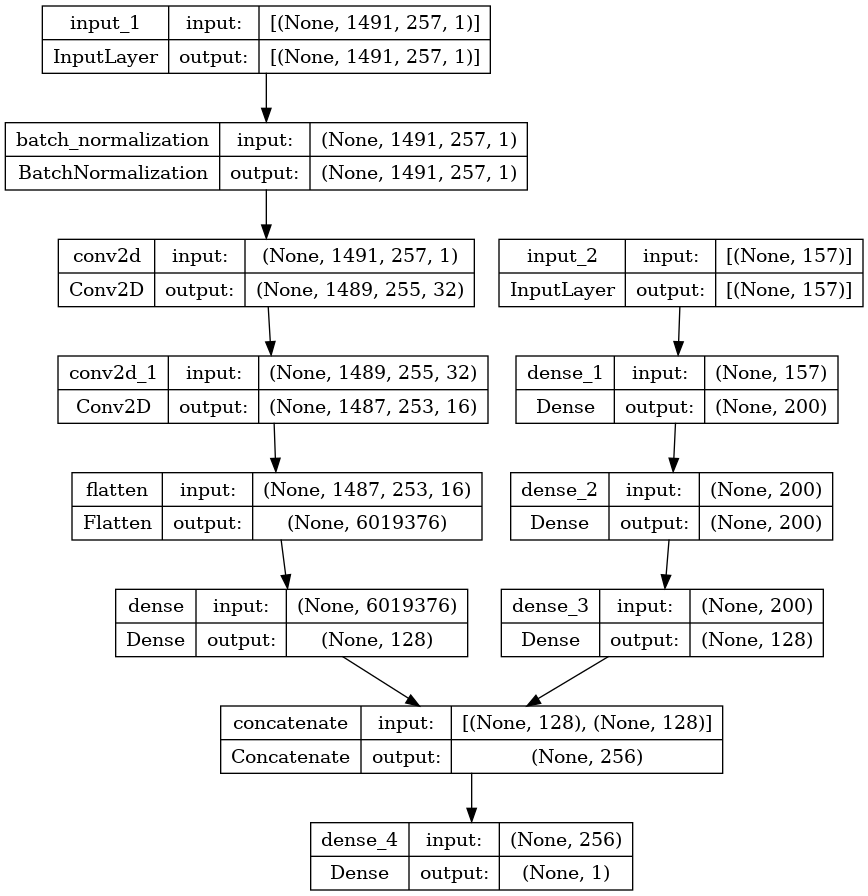

In [69]:
plot_model(model_class,show_shapes=True, show_layer_names=True)

## Compiling the model

In [70]:
model_class.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

## Training the model

In [71]:
history = model_class.fit([X_train_spectro,X_train_mfcc],y_train,epochs=5, batch_size=2, validation_split=0.2)

Epoch 1/5
259/259 [==============================] - 2559s 10s/step - loss: 2.6783 - accuracy: 0.8958 - recall: 0.7879 - precision: 0.8000 - val_loss: 0.3085 - val_accuracy: 0.9923 - val_recall: 1.0000 - val_precision: 0.9756
Epoch 2/5
259/259 [==============================] - 2523s 10s/step - loss: 0.0220 - accuracy: 0.9942 - recall: 0.9848 - precision: 0.9924 - val_loss: 0.3753 - val_accuracy: 0.9923 - val_recall: 1.0000 - val_precision: 0.9756
Epoch 3/5
259/259 [==============================] - 2531s 10s/step - loss: 0.0067 - accuracy: 0.9961 - recall: 0.9924 - precision: 0.9924 - val_loss: 0.4602 - val_accuracy: 0.9692 - val_recall: 0.9250 - val_precision: 0.9737
Epoch 4/5
259/259 [==============================] - 2478s 10s/step - loss: 3.7460e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.3669 - val_accuracy: 0.9846 - val_recall: 0.9750 - val_precision: 0.9750
Epoch 5/5
259/259 [==============================] - 2536s 10s/step - loss: 1.8527e-04 - acc

## Metrics plots

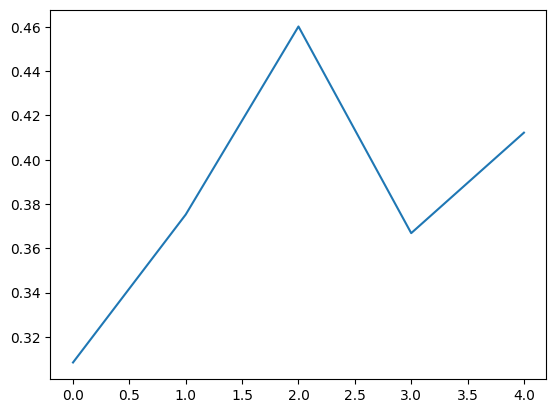

In [128]:
plt.plot(history.history['val_loss'])

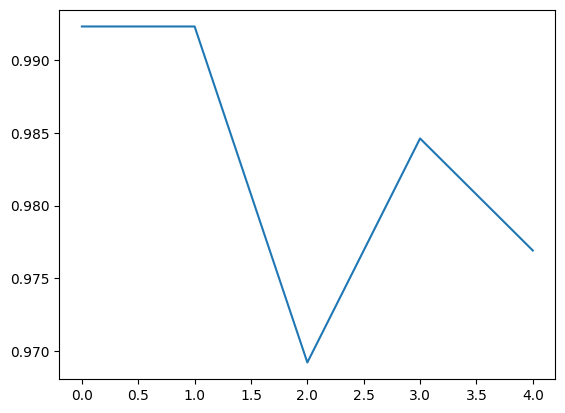

In [73]:
plt.plot(history.history['val_accuracy'])

In [74]:
history.history

{'loss': [2.678316831588745,
  0.02201787568628788,
  0.006715578958392143,
  0.0003745979047380388,
  0.0001852674613473937],
 'accuracy': [0.8957529067993164,
  0.9942085146903992,
  0.9961389899253845,
  1.0,
  1.0],
 'recall': [0.7878788113594055,
  0.9848484992980957,
  0.9924242496490479,
  1.0,
  1.0],
 'precision': [0.800000011920929,
  0.9923664331436157,
  0.9924242496490479,
  1.0,
  1.0],
 'val_loss': [0.30848175287246704,
  0.3752809464931488,
  0.46017009019851685,
  0.3668704330921173,
  0.4122290015220642],
 'val_accuracy': [0.9923076629638672,
  0.9923076629638672,
  0.9692307710647583,
  0.9846153855323792,
  0.9769230484962463],
 'val_recall': [1.0,
  1.0,
  0.925000011920929,
  0.9750000238418579,
  0.949999988079071],
 'val_precision': [0.9756097793579102,
  0.9756097793579102,
  0.9736841917037964,
  0.9750000238418579,
  0.9743589758872986]}

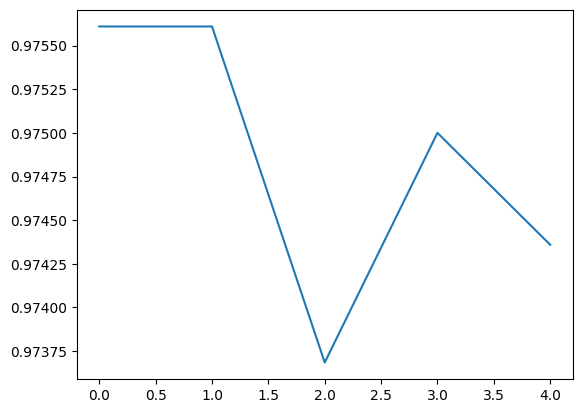

In [75]:
plt.plot(history.history['val_precision'])

In [76]:
yhat=model_class.predict([X_test_spectro,X_test_mfcc])

6/6 [==============================] - 21s 3s/step


In [77]:
yhat=[1 if pred > 0.5 else 0 for pred in yhat]

In [78]:
tf.math.reduce_sum(yhat).numpy()

47

In [79]:
tf.math.reduce_sum(y_test).numpy()

45.0

In [80]:
yhat[:10]

[0, 1, 0, 0, 0, 0, 1, 0, 0, 0]

In [81]:
y_test[:10].astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

## Processing and testing long audio file

In [82]:
mp3=load_mono_audio('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3')

In [83]:
def preprocess_mp3(sample):
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [84]:
from pydub import AudioSegment

In [143]:
def extract_mp3_slices(mp3_file_path, sequence_length=16000, sequence_stride=16000, max_length=157, demo_sample_rate=22050):
    # Load audio file using librosa
    audio, _ = librosa.load(mp3_file_path, sr=demo_sample_rate)
    
    spectro_slices = []
    mfcc_slices = []
    for i in range(0, len(audio), sequence_stride):
        if i + sequence_length <= len(audio):
            slice_data = audio[i:i + sequence_length]
            spectro_slices.append(preprocess_mp3(slice_data))
            mfcc_feat = librosa.feature.mfcc(y=slice_data,sr=demo_sample_rate,n_mfcc=100)  # n_mfcc should be set to 13
            mfcc_feat = mfcc_feat.mean(axis=0)
            if mfcc_feat.shape[0] < max_length:
                padded_mfcc = pad_sequences([mfcc_feat], dtype='float32', padding='post', maxlen=max_length)
            else:
                padded_mfcc = mfcc_feat[:max_length]
            mfcc_slices.append(padded_mfcc)
    
    spectrography = np.array([tensor.numpy() for tensor in spectro_slices])
    mfcc_testing = np.vstack(mfcc_slices)
    return spectrography, mfcc_testing


mp3_file_path = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3"
spectrography, mfcc_testing = extract_mp3_slices(mp3_file_path, sequence_length=48000, sequence_stride=48000)

In [99]:
# mfcc_testing=np.array(mfcc_testing)

In [144]:
spectrography.shape

(82, 1491, 257, 1)

In [145]:
mfcc_testing.shape

(82, 157)

In [146]:
yhat_model=model_class.predict([spectrography, mfcc_testing])

3/3 [==============================] - 11s 3s/step


In [147]:
yhat_model

array([[6.6352808e-01],
       [7.8126168e-01],
       [7.1847785e-01],
       [2.4053879e-01],
       [3.1923884e-01],
       [2.5299525e-05],
       [9.9999535e-01],
       [6.8203270e-05],
       [3.4567675e-01],
       [3.9158082e-01],
       [4.9541679e-01],
       [3.9839479e-01],
       [8.9021271e-01],
       [4.4068521e-01],
       [7.9604113e-01],
       [3.6698008e-01],
       [5.2597141e-01],
       [4.1053715e-01],
       [3.6589889e-05],
       [5.2943792e-02],
       [4.8122916e-01],
       [3.6680219e-01],
       [2.3214396e-02],
       [8.3665036e-02],
       [7.0887756e-01],
       [4.1394246e-01],
       [4.9153015e-01],
       [1.4096069e-01],
       [1.8423186e-01],
       [8.9655876e-02],
       [3.4197000e-01],
       [4.2298213e-01],
       [3.6332387e-01],
       [2.4215449e-03],
       [7.7811337e-01],
       [7.3244959e-01],
       [2.3821759e-01],
       [1.6165671e-01],
       [6.4658120e-02],
       [1.2440880e-01],
       [2.1176200e-01],
       [1.584347

In [148]:
yhat_model = [1 if prediction > 0.99 else 0 for prediction in yhat_model]

In [149]:
from itertools import groupby

In [152]:
yhat_model = [key for key, group in groupby(yhat_model)]
calls = tf.math.reduce_sum(yhat_model).numpy()

In [153]:
calls

5

In [157]:
results = {}
forest_folder="/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings"
for file in os.listdir(forest_folder):
    test_spectro, test_mfcc = extract_mp3_slices(os.path.join(forest_folder,file))
    yhat_all = model_class.predict([test_spectro,test_mfcc])
    yhat_all = [1 if prediction > 0.99 else 0 for prediction in yhat_all]
    yhat_all = [key for key, group in groupby(yhat_all)]
    calls_all = tf.math.reduce_sum(yhat_all).numpy()
    results[file] = calls_all

8/8 [==============================] - 29s 4s/step


In [159]:
import csv

In [160]:
csv_file_name = "results.csv"
# Open the CSV file in write mode and write the dictionary data
with open(csv_file_name, 'w', newline='') as csvfile:
    # Define the CSV writer
    csv_writer = csv.writer(csvfile)

    # Write the header row
    csv_writer.writerow(['recording', 'capuchin_calls'])

    # Write dictionary data to CSV file
    for audio_name, call_count in results.items():
        csv_writer.writerow([audio_name, call_count])

## Exporting the model

In [90]:
import pickle

In [91]:
pickle.dump(model_class,open('audio_classification.pkl','wb'))